In [12]:
import torch as t
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torchvision.models import resnet34, ResNet34_Weights, resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchinfo import summary
import inspect

In [13]:
device = "cuda" if t.cuda.is_available() else "cpu"

### Data processing and setup

In [14]:
# Hyperparameters / data parameters
batch_size = 64

# The training data is split into train and val, test is separate
train_frac = 0.7

num_workers = 6

mu = [0.5071, 0.4865, 0.4409]
std = [0.2673, 0.2564, 0.2762]

In [22]:
# Data transforms

transform_raw = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mu, std),
])

In [23]:
# Class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp',
    'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain',
    'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal',
    'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [24]:
# Load dataset for visualisation only
raw_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform_raw)

Files already downloaded and verified


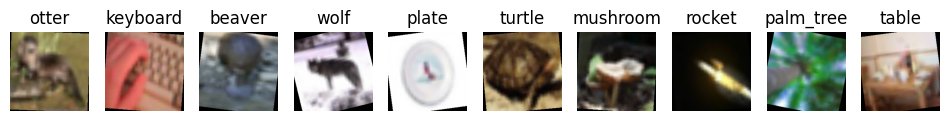

In [33]:
# Visualise some images
start = 100
end = 110
fig, axes = plt.subplots(1, end-start, figsize=(12, 3))
for i in range(start, end):
    image, label = raw_dataset[i]
    image = image.permute(1, 2, 0)
    axes[i-start].imshow(image)
    axes[i-start].set_title(cifar100_classes[label])
    axes[i-start].axis("off")
plt.show()

In [34]:
# Load dataset
train_set = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
# Get train and val set lengths
train_size = int(train_frac * len(train_set))
val_size = len(train_set) - train_size
test_size = len(test_set)

In [36]:
# Split into train, val, test, and convert to DataLoaders
train_set, val_set = random_split(train_set, lengths=[train_size, val_size])

In [37]:
# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6, persistent_workers=True) 
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=6, persistent_workers=True) 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=6, persistent_workers=True)

### Model definition

In [38]:
num_classes = 100
model = models.resnet50(pretrained=True)

c:\Users\moosa\anaconda3\envs\standard_ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\moosa\anaconda3\envs\standard_ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [40]:
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [41]:
# Quick check to see if the model's functioning okay :)
model.eval()
logits = model(test_set[0][0].unsqueeze(0).to(device))
print(t.argmax(logits, dim=-1).item())

94


### Training loop

In [42]:
# eval and train_one_epoch functions, very standard

def train_one_epoch(model, train_loader, criterion, optimiser, device):
    total_loss = 0
    num_correct = 0
    num_samples = len(train_loader.dataset)
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)
        num_correct += (t.argmax(logits, dim=-1) == labels).sum().item()
        loss = criterion(logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
    return total_loss / len(train_loader), num_correct / num_samples

def eval(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_correct = 0
    num_samples = len(val_loader.dataset)
    with t.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            num_correct += (t.argmax(logits, dim=-1) == labels).sum().item()
            loss = criterion(logits, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader), num_correct / num_samples

In [45]:
lr = 5e-03
wd = 5e-04

criterion = nn.CrossEntropyLoss()
optimiser = t.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [46]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 10

for epoch in range(1, num_epochs+1):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimiser, device)
    val_loss, val_accuracy = eval(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch}/{num_epochs} | Train loss : {train_loss:.3e} | Train accuracy : {train_accuracy*100:.3f}% | Val loss : {val_loss:.3e} | Val accuracy : {val_accuracy*100:.3f}%")

100%|██████████| 235/235 [04:50<00:00,  1.24s/it]


Epoch 1/10 | Train loss : 2.773e+00 | Train accuracy : 40.446% | Val loss : 2.486e+00 | Val accuracy : 46.820%


100%|██████████| 235/235 [04:01<00:00,  1.03s/it]


Epoch 2/10 | Train loss : 2.362e+00 | Train accuracy : 49.429% | Val loss : 2.764e+00 | Val accuracy : 46.293%


  1%|▏         | 7/547 [00:08<11:08,  1.24s/it]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020C9A617060>
Traceback (most recent call last):
  File "c:\Users\moosa\anaconda3\envs\standard_ml\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\moosa\anaconda3\envs\standard_ml\Lib\site-packages\torch\utils\data\dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\moosa\anaconda3\envs\standard_ml\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\moosa\anaconda3\envs\standard_ml\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


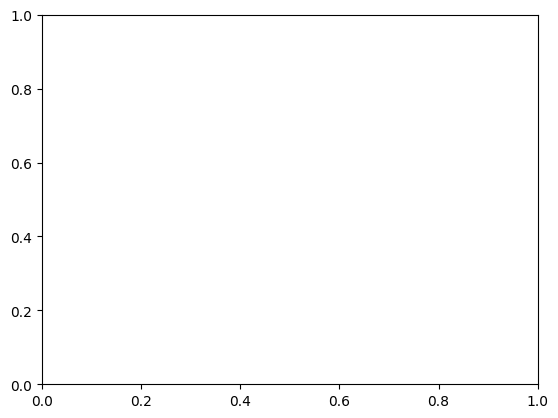

In [69]:
epochs = list(range(1, num_epochs+1))

loss_fig = plt.figure()
plt.plot(epochs, train_losses)
plt.plot(epochs, val_losses)
plt.legend(["Train", "Val"])
plt.title("Loss evolution")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

acc_fig = plt.figure()
plt.plot(epochs, train_accuracies)
plt.plot(epochs, val_accuracies)
plt.legend(["Train", "Val"])
plt.title("Accuracy evolution")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [75]:
from datetime import datetime
time = datetime.now().strftime("%d%m%Y-%H%M%S")
t.save(model.state_dict(), f"./model_{time}.pth")